# Numerical Methods in Financial Engineering
### Laure MICHAUD & Tim HOUDAYE & Steven WORICK

Implementation of the research paper **Pricing early-exercice and discrete barrier options by Fourier-cosine series expansions** from *F. Fang & C. W.  Oosterlee* (2009)


# Packages

In [ ]:
import numpy as np
import matplotlib.pylab as plt

import scipy.integrate as integrate
from scipy.special import gamma as gamma_func
from scipy import optimize

#  Functions and Classes

In [ ]:
class SBM(object):
    '''
    Standard Brownian Motion Object
    '''
    def __init__(self, sigma, rf, mat):
      '''
      Initialize the class.
      :param sigma: Volatility of the brownian motion
      :param rf: Risk Free rate of the economy
      :param mat: Maturity of the option
      '''
      self.sigma = sigma
      self.rf = rf
      self.mat = mat

    def characteristic_function(self, grid):
      '''
      Characteristic function of the SBM
      :grid: Integral discretization
      :return: Values of SBM's characteristic function given a grid
      '''
      phi = np.exp(grid * self.rf * self.mat * 1j
              - grid**2 * self.sigma**2 * self.mat / 2)
      return phi

    def integral_truncation(self):
      '''
      Truncation range to compute the ingration. Eq. 74 in the paper
      :param x_0: log-moneyness ln(S_0/K)
      :return: a and b, bound of integration
      '''

      L = 10
      c1 = (self.rf - 0.5 * self.sigma**2 * self.mat)
      c2 = self.sigma**2 * self.mat

      a = c1 - L * c2**.5
      b = c1 + L * c2**.5
      return a, b

In [ ]:
class Heston(object):
  def __init__(self, kappa, theta, rho, eta, rf, sigma, mat):
    '''
    :param kappa: Rate at which the dynamic return to its long term value
    :param theta: Long variance, or long-run average variance of the price
    :param rho: Correlation of the two Wienner processes
    :param eta: Volatility of volatility
    :param sigma: Initial variance of the asset price
    :param rf: Risk free rate
    :param mat: Maturity
    '''
    self.kappa = kappa
    self.theta = theta
    self.rho = rho
    self.eta = eta
    self.sigma = sigma
    self.rf = rf
    self.mat = mat
    
  
  def characteristic_function(self, grid):
    '''
    Characteristic function of the Heston model
    :grid: Integral discretization
    :return: Values of Heston's characteristic function given a grid
    '''
    # Keep the parameters into variables in order to simplify the notation
    kappa, theta, sigma  = self.kappa, self.theta, self.sigma, 
    rho, eta, rf, mat = self.rho, self.eta, self.rf, self.mat

    # Compute D and G
    D = np.sqrt( (kappa - 1j*rho*eta*grid)**2 + (grid**2 + 1j*grid)*eta**2 )
    G = (kappa - 1j*rho*eta*grid - D) / (kappa - 1j*rho*eta*grid + D)

    # Compute the two part of phi
    first_part = np.exp( 1j*grid*rf*mat + sigma/eta**2 \
                        * ((1-np.exp(-D*mat)) / (1-G*np.exp(-D*mat))) \
                        * (kappa - 1j*rho*eta*grid - D) ) 
    
    second_part = np.exp( kappa*theta/eta**2 \
                         * (mat * (kappa - 1j*rho*eta*grid - D) - 2*np.log((1-G*np.exp(-D*mat)) / (1-G))) )

    # Construct the characteristic function of the Heston model
    phi = first_part * second_part

    return phi

  def integral_truncation(self):
    '''
    Truncation range to compute the ingration. Eq. 74 in the paper
    :param x_0: log-moneyness ln(S_0/K)
    :return: a and b, bound of integration
    '''

    # Keep the parameters into variables in order to simplify the notation
    kappa, theta, sigma  = self.kappa, self.theta, self.sigma
    rho, eta, rf, mat = self.rho, self.eta, self.rf, self.mat

    L = 12
    c1 = rf * mat \
        + (1 - np.exp(-kappa * mat)) \
        * (theta - sigma)/2 / kappa - theta * mat / 2 

    c2 = 1/(8 * kappa**3) \
        * (eta * mat * kappa * np.exp(-kappa * mat) \
        * (sigma - theta) * (8 * kappa * rho - 4 * eta) \
        + kappa * rho * eta * (1 - np.exp(-kappa * mat)) \
        * (16 * theta - 8 * sigma) + 2 * theta * kappa * mat \
        * (-4 * kappa * rho * eta + eta**2 + 4 * kappa**2) \
        + eta**2 * ((theta - 2 * sigma) * np.exp(-2*kappa*mat) \
        + theta * (6 * np.exp(-kappa*mat) - 7) + 2 * sigma) \
        + 8 * kappa**2 * (sigma - theta) * (1 - np.exp(-kappa*mat)))

    a = c1 - L * np.abs(c2)**.5
    b = c1 + L * np.abs(c2)**.5
    return a, b

In [ ]:
class Fourier_cosine_method(object):
  def __init__(self, model, log_moneyness, call_option, grid_size):
    '''
    :param model: Model to be used to price the option
    :param log_moneyness: Float or list of log-moneyness given a strike K and an underlying price S_0
    :param call_option: Boolean to specify wether it is a call or a put option to price
    :param grid_size: Number of point to be used on the grid
    '''
    self._model = model
    self._log_moneyness = log_moneyness
    self._grid_size = grid_size
    self._call_option = call_option

    # Get the bound of integration
    self._a , self._b = self._model.integral_truncation()

  def cosine_expansion(self):
    '''
    This function compute the price of an option given a certain model using the Fourier cosine expansion methods
    :return: Option premium
    '''

    # Compute the k
    k = np.arange(self._grid_size, dtype=complex)[:, np.newaxis]

    # Compute V for the call and put option using the xhi and psi cosine series coefficients
    if self._call_option:
      xhi, psi = self.get_xhi_psi_coefficients(k, 0, self._b)
      v_mat = 2 / (self._b - self._a) * (xhi - psi)
    else:
      xhi, psi = self.get_xhi_psi_coefficients(k, self._a, 0)
      v_mat = 2 / (self._b - self._a) * (-xhi + psi)

    # Compute the model characteristic function
    char_mat = self._model.characteristic_function(k * np.pi/(self._b-self._a))

    # Exponential part
    exp_mat = np.exp(1j * k * np.pi * (self._a - self._log_moneyness)/(self._b - self._a))

    # Grid of weight with 1/2 to start
    weights = np.append(.5, np.ones(self._grid_size-1))

    return np.exp(-self._model.rf * self._model.mat) * np.dot(weights, char_mat * exp_mat * v_mat).real
  
  def get_xhi_psi_coefficients(self, k, x_1, x_2):
    '''
    This function compute the xhi and psi function for given parameters.
    :param k: Log-moneyness of the options
    :param x_1: Lower bound of the inner integration interval
    :param x_2: Upper bound of the inner integration interval
    :return: The cosine series coefficients xhi and psi 
    '''

    # Xhi cosine serie coefficients
    xhi = (np.cos(k * np.pi * (x_2-self._a)/(self._b-self._a)) * np.exp(x_2) - np.cos(k * np.pi * (x_1-self._a)/(self._b-self._a)) * np.exp(x_1)
          + k * np.pi/(self._b-self._a) * (np.sin(k * np.pi * (x_2-self._a)/(self._b-self._a)) * np.exp(x_2) - np.sin(k * np.pi * (x_1-self._a)/(self._b-self._a)) * np.exp(x_1)))\
          / (1 + (k * np.pi/(self._b-self._a))**2)

    # Psi cosine serie coefficients
    psi = (np.sin(k[1:] * np.pi * (x_2-self._a)/(self._b-self._a)) - np.sin(k[1:] * np.pi * (x_1-self._a)/(self._b-self._a))) / (k[1:] * np.pi/(self._b-self._a))
    psi = np.vstack([(x_2 - x_1) * np.ones_like(self._a), psi])
    return xhi, psi

In [ ]:
class Fourier_cosine_method_bermuda(object):
  def __init__(self, model, log_moneyness, grid_size, M, call_option):
    '''
    :param model: Model to be used to price the option
    :param log_moneyness: Float or list of log-moneyness given a strike K and an underlying price S_0
    :param grid_size: Number of point to be used on the grid
    :param M: Number of early exercices time
    :param call_option: Boolean to specify wether it is a call or a put option to price
    '''
    self._model = model
    self._log_moneyness = log_moneyness
    self._grid_size = grid_size
    self._call_option = call_option
    self._M = M

    # Get the bound of integration
    self._a , self._b = self._model.integral_truncation()

  def cosine_expansion(self):
    '''
    This function compute the price of an option given a certain model using the Fourier cosine expansion methods
    :return: Option premium
    '''

    # Compute the k
    k = np.arange(self._grid_size, dtype=complex)[:, np.newaxis]

    # Compute the payoff for the terminal time
    if self._call_option:
      xhi, psi = self.get_xhi_psi_coefficients(k, 0, self._b)
      v_mat = 2 / (self._b - self._a) * (xhi - psi)
    else:
      xhi, psi = self.get_xhi_psi_coefficients(k, self._a, 0)
      v_mat = 2 / (self._b - self._a) * (-xhi + psi)

    # Compute the model characteristic function
    char_mat = self._model.characteristic_function(k * np.pi/(self._b - self._a))

    # Grid of weight with 1/2 to start
    weights = np.append(.5, np.ones(self._grid_size-1))

    # Loop on early exercice time
    for t_m in range(self._M,1,-1):

      # Approximation of the continuation function
      c_hat = lambda x: np.exp(-self._model.rf * self._model.mat) * np.dot(weights, char_mat * np.exp(1j * k * np.pi * (self._a - x)/(self._b - self._a)) * v_mat).real

      # Compute the x_star ***** DOESN'T WORK 
      #x_star = self.find_x_star(c_hat, k)

      # We put a fixed value instead
      #x_star = (self._b -  self._a)/2.0

      # Upper bound
      x_star = self._b

      # Lower bound
      #x_star = self._a

      # Construct the u vector given v_mat for time t_m
      u = self.get_u_vector(v_mat, k)

      # Compute the G and C_hat matrix given x_star
      if self._call_option:
        xhi, psi = self.get_xhi_psi_coefficients(k, x_star, self._b)
        G = 2 / (self._b - self._a) * (xhi - psi)
        C_hat = self.get_C_hat_matrix(self._a, x_star, u)

      else:
        xhi, psi = self.get_xhi_psi_coefficients(k, self._a, x_star)
        G = 2 / (self._b - self._a) * (xhi - psi)
        C_hat = self.get_C_hat_matrix(x_star, self._b, u)

      # Compute v_mat for time t_m
      v_mat = G + C_hat

    # Exponential part
    exp_mat = np.exp(1j * k * np.pi * (self._a - log_moneyness)/(self._b - self._a))

    # Reconstruct the final option price
    return np.exp(-self._model.rf * self._model.mat) * np.dot(weights, char_mat * exp_mat * v_mat).real


######################################################     
#     FUNCTIONS TO COMPUTE THE VALUATION FUNCTION    #
#                                                    #
######################################################

  def get_xhi_psi_coefficients(self, k, x_1, x_2):
    '''
    This function compute the xhi and psi function for given parameters.
    :param k: Log-moneyness of the options
    :param x_1: Lower bound of the inner integration interval
    :param x_2: Upper bound of the inner integration interval
    :return: The cosine series coefficients xhi and psi 
    '''

    # Xhi cosine serie coefficients
    xhi = (np.cos(k * np.pi * (x_2-self._a)/(self._b-self._a)) * np.exp(x_2) - np.cos(k * np.pi * (x_1-self._a)/(self._b-self._a)) * np.exp(x_1)
          + k * np.pi/(self._b - self._a) * (np.sin(k * np.pi * (x_2-self._a)/(self._b-self._a)) * np.exp(x_2) - np.sin(k * np.pi * (x_1-self._a)/(self._b-self._a)) * np.exp(x_1)))\
          / (1 + (k * np.pi/(self._b-self._a))**2)

    # Psi cosine serie coefficients
    psi = (np.sin(k[1:] * np.pi * (x_2-self._a)/(self._b-self._a)) - np.sin(k[1:] * np.pi * (x_1-self._a)/(self._b-self._a))) / (k[1:] * np.pi/(self._b-self._a))
    psi = np.vstack([(x_2 - x_1) * np.ones_like(self._a), psi])
    return xhi, psi

######################################################     
#     FUNCTIONS TO COMPUTE FIND THE OPTIMAL          #
#                   x VALUE                          #
######################################################
  
  def get_payoff(self, x, k):
    '''
    Compute the payoff of a call or put option
    :param x: Log price of the underlying asset
    :param k: Strike of the option
    :return: Payoff of the option
    '''
    put = np.logical_not(self._call_option)
    return np.max((1*self._call_option - 1*put)*k*(1-np.exp(x)))
  
  def find_x_star(self, c, k):
    '''
    Function which will return the optimal x which solve c_hat = payoff
    :param c: Approximation of the continuation function
    :param k: Strike
    :return: x_star the optimal value to solve the equation
    '''
    # Define the function to optim
    optim = lambda x: c(x) - self.get_payoff(x, k)
    x_star = optimize.fsolve(optim, x0 = k)

    # Conditions on x_star
    if x_star > self._b:
      x_star = self._b
    elif x_star < self._a:
      x_star = self._a

    return x_star



######################################################     
#     FUNCTIONS TO COMPUTE THE APPROXIMATION         #
#         OF THE CONTINUATION FUNCTION               #
######################################################

  def get_u_vector(self, v_mat, k):
    '''
    Compute the u vector to get the approximation of the continuation function on t_{m}.
    :param model: Model which contains the characteristic function to be used
    :param v_mat: Cosine coefficients of the option value at time t_{m+1}
    :param k: Log-moneyness of the options
    :return: The U vector to compute the approximation of the continuation function
    '''
    # Construct the U vector
    u = np.ones(self._grid_size, dtype=complex)[:, np.newaxis]

    # Complete the vector
    for j in range(0, len(u)):
      if j == 0:
        u[j] = 0.5 * self._model.characteristic_function(0) * v_mat[j]
      else:
        u[j] = self._model.characteristic_function(j * np.pi/(self._b-self._a)) * v_mat[j]  
    return u

  def get_Mc_Ms_matrix(self, x_1, x_2):
    '''
    Compute M_c and M_s matrix which will be used in the computation of the continuous function.
    :param x_1: Lower bound of the inner integration interval
    :param x_2: Upper bound of the inner integration interval
    :return: M_c and M_s matrix which are time invariant
    '''

    # Initialize both matrix
    m_c = np.ones((self._grid_size, self._grid_size), dtype=complex)
    m_s = np.ones((self._grid_size, self._grid_size), dtype=complex)

    # Loop on row and columns to compute the coefficient
    for k in np.arange(self._grid_size):
      for j in np.arange(self._grid_size):
        # Compute m_c
        if k == j:
          m_c[k,j] = np.pi*1j*(x_2-x_1)/(self._b-self._a)
        else:
          m_c[k,j] = ( np.exp(1j*(j+k) * np.pi*(x_2-self._a)/(self._b-self._a)) - np.exp(1j*(j+k) * np.pi*(x_1-self._a)/(self._b-self._a)) )/(j+k)
        
        # Compute m_s
        if k == j:
          m_s[k,j] = np.pi*1j*(x_2-x_1)/(self._b-self._a)
        else:
          m_s[k,j] = ( np.exp(1j*(j+k) * np.pi*(x_2-self._a)/(self._b-self._a)) - np.exp(1j*(j+k) * np.pi*(x_1-self._a)/(self._b-self._a)) )/(j+k)
    return m_c, m_s

  def get_C_hat_matrix(self, x_1, x_2, u):
    '''
    Compute the C_hat function which is the approximation of the continuation function between x_1 and x_2.
    Eq. 36 in our paper
    :param x_1: Lower bound of the inner integration interval
    :param x_2: Upper bound of the inner integration interval
    '''

    # Get the Mc and Ms matrix between x_1 and x_2
    m_c, m_s = self.get_Mc_Ms_matrix(x_1, x_2)

    # Compute the C_hat value between x_1 and x_2 
    c_hat = np.imag(np.dot((m_c + m_s),u)) * np.exp(-self._model.rf*self._model.mat)/np.pi

    return c_hat
  

In [ ]:
class Fourier_Carr_Madan_Method(object):

  def __init__(self):
    pass

  @staticmethod
  def Call_Price_Heston(S, K, T, r, kappa, theta, nu, rho, V_0, alpha=1, L=1000):
    '''
    Function to compute option price using Fourier Carr-Madan method
    :param S: Initial Price
    :param K: Strike
    :param r: risk free rate
    :param kappa: Rate at which the dynamic return to its long term value
    :param theta: Long variance, or long-run average variance of the price
    :param nu: Long term value of the dynamic
    :param rho: correlation of the two Wienner processes
    :param V_0: initial volatility 
    :param alpha: Damping factor (alpha>0) typically alpha = 1
    :param L: Truncation bound for the integral
    '''
    # Complex number
    i = complex(0,1)

    b = lambda x: (kappa - 1j*rho*nu*x)
    gamma = lambda x: (np.sqrt(nu**(2) * (x**2+1j+x) + b(x)**2))
    a = lambda x: (b(x) / gamma(x)) * np.sinh(T*.5*gamma(x))
    c = lambda x:(gamma(x) * np.cosh(.5*T*gamma(x))) / np.sinh(T*.5*gamma(x)+b(x))
    d = lambda x:(kappa*theta*T*b(x) / nu**2)

    f = lambda x:(1j * (np.log(S)+r*T) * x + d(x))
    g = lambda x:(np.cosh(T*.5*gamma(x)) + a(x)) ** (2*kappa*theta / nu**2)
    h = lambda x:(- (x**2+1j*x) * V_0 / c(x))

    phi = lambda x:(np.exp(f(x)) * np.exp(h(x)/g(x))) # Characteristics function

    integrand = lambda x:( np.real( phi(x-1j*(alpha+1)) / ((alpha+1j*x) * (alpha+1+1j*x)) ) * np.exp(-1j*np.log(K)*x) )
    integral = integrate.quad(integrand, 0, L)
    price = ( np.exp(-r*T - alpha*np.log(K)) / np.pi ) * integral[0]
    return price

# Part I : European Options

## Part I. a) Compute prices using differents pricing methods

In [ ]:
# SBM Cosine Expansion price
price, strike = 100, 90
riskfree, maturity = 0, 180/365
sigma = .15
log_moneyness = np.log(price/strike)

model = SBM(sigma, riskfree, maturity)
method = Fourier_cosine_method(model, log_moneyness, True, 2**10)
premium = method.cosine_expansion()
print(premium)

[0.12566444]


In [ ]:
# Heston Cosine Expansion price
kappa = 1.5768
theta = .12**2
eta = .5751
rho = -.0
sigma = .12**2
model = Heston(kappa, theta, rho, eta, riskfree, sigma, maturity)
method = Fourier_cosine_method(model, log_moneyness, True, 2**10)
premium = method.cosine_expansion()
print(premium)

[0.12337098]


In [ ]:
# Heston price Carr-Madan Method *** A MODIFIER car le prix n'est pas en log moneyness***
price = Fourier_Carr_Madan_Method.Call_Price_Heston(100, 90, maturity, riskfree, kappa, theta, eta, rho, sigma)
print(price)

1.3022666030299189e-05


/usr/local/lib/python3.7/dist-packages/scipy/integrate/quadpack.py:453: ComplexWarning: Casting complex values to real discards the imaginary part
  return _quadpack._qagse(func,a,b,args,full_output,epsabs,epsrel,limit)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


In [ ]:
prices = []
strikes = np.arange(20,180,1)
for k in strikes:
  prices.append(Fourier_Carr_Madan_Method.Call_Price_Heston(100, k, maturity, riskfree, kappa, theta, eta, rho, sigma))

/usr/local/lib/python3.7/dist-packages/scipy/integrate/quadpack.py:453: ComplexWarning: Casting complex values to real discards the imaginary part
  return _quadpack._qagse(func,a,b,args,full_output,epsabs,epsrel,limit)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


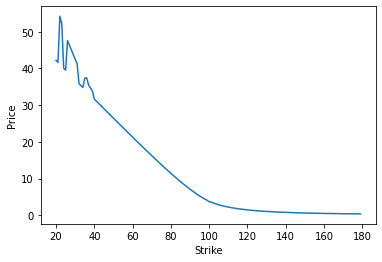

In [ ]:
plt.plot(strikes, prices)
plt.xlabel("Strike")
plt.ylabel("Price")
plt.show()

## Part I. b) Multiple strikes

In [ ]:
# Number of option to price
grid_size = 2000

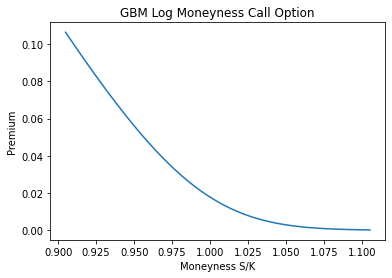

In [ ]:
# SBM Cosine Expansion price

# Initialize parameters
riskfree, maturity = 0, 1/12
sigma = .15
price = 1
strike = np.exp(np.linspace(-.1, .1, grid_size))
log_moneyness = np.log(price/strike)
call_option = False

# Initialize the model and method
model = SBM(sigma, riskfree, maturity)
method = Fourier_cosine_method(model, log_moneyness, call_option, grid_size)

# Compute premium of options
premium = method.cosine_expansion()

# Plot the strike/premium
plt.plot(strike, premium)
plt.xlabel("Moneyness S/K")
plt.ylabel("Premium")
if call_option:
  plt.title("GBM Log Moneyness Call Option")
  plt.savefig('GMB_Call.png')
else:
  plt.title("GBM Log Moneyness Put Option")
  plt.savefig('GMB_Put.png')

#plt.show()


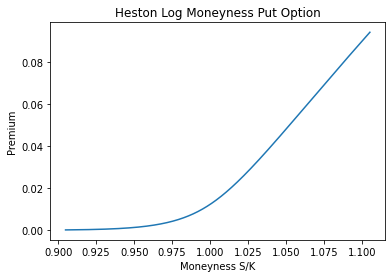

In [ ]:
# Heston Cosine Expansion price

# Initialize parameters
kappa = 1.5768
theta = .12**2
eta = .5751
rho = -.0
sigma = .12**2
price = 1
strike = np.exp(np.linspace(-.1, .1, grid_size))
maturity = 1/12
riskfree = np.zeros(grid_size)
log_moneyness = np.log(price/strike)
call_option = False

# Initialize the model and method
model = Heston(kappa, theta, rho, eta, riskfree, sigma, maturity)
method = Fourier_cosine_method(model, log_moneyness, call_option, grid_size)

# Compute premium of options
premium = method.cosine_expansion()

# Plot the strike/premium
plt.plot(strike, premium)
plt.xlabel("Moneyness S/K")
plt.ylabel("Premium")
if call_option:
  plt.title("Heston Log Moneyness Call Option")
  plt.savefig('Heston_Call.png')
else:
  plt.title("Heston Log Moneyness Put Option")
  plt.savefig('Heston_Put.png')

#plt.show()


# Part II. Bermuda Options

## Part II. a) Compute bermuda option prices 

In [ ]:
# SBM Cosine Expansion price
price, strike = 100, 90
riskfree, maturity = 0, 1.0
sigma = .15
log_moneyness = np.log(price/strike)

model = SBM(sigma, riskfree, maturity)
method = Fourier_cosine_method_bermuda(model, log_moneyness, grid_size, 2, True)
premium = method.cosine_expansion()
print(premium)

[0.10419196]


In [ ]:
# Heston Cosine Expansion price
kappa = 1.5768
theta = .12**2
eta = .5751
rho = -.0
sigma = .12**2
model = Heston(kappa, theta, rho, eta, riskfree, sigma, maturity)
method = Fourier_cosine_method_bermuda(model, log_moneyness, grid_size, 2, True)
premium = method.cosine_expansion()
print(premium)

[0.11033636]


## Part II. b) Compute bermuda option prices fro multiple strikes

In [ ]:
# SBM Cosine Expansion price

# Initialize the parameters
price = 1.0
riskfree, maturity = 0, 1/12
sigma = .15
strike = np.exp(np.linspace(-.1, .1, grid_size))
call_option = False
stopping_time = 2
grid_size = 100
premiums = []

# Initialize the model
model = SBM(sigma, riskfree, maturity)

# Loop on strikes
for k in strike:
  log_moneyness = np.log(price/k)
  method = Fourier_cosine_method_bermuda(model, log_moneyness, grid_size, stopping_time, call_option)
  result = method.cosine_expansion()
  #if result < 0.0:
   # result = 0.0
  premiums.append(result)


/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


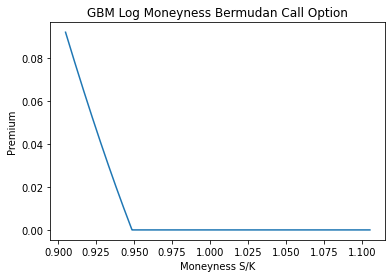

In [ ]:
plt.plot(strike, premiums)
plt.xlabel("Moneyness S/K")
plt.ylabel("Premium")
if call_option:
  plt.title("GBM Log Moneyness Bermudan Call Option")
  plt.savefig('GBM_B_Call_mid.png')
else:
  plt.title("GBM Log Moneyness Bermudan Put Option")
  plt.savefig('GBM_B_Put_mid.png')

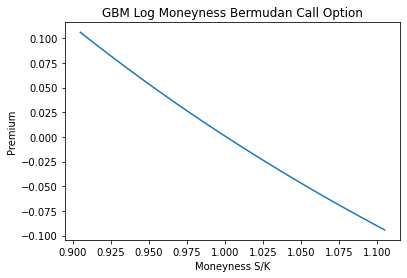

In [ ]:
plt.plot(strike, premiums)
plt.xlabel("Moneyness S/K")
plt.ylabel("Premium")
if call_option:
  plt.title("GBM Log Moneyness Bermudan Call Option")
  plt.savefig('GBM_B_Call_lower.png')
else:
  plt.title("GBM Log Moneyness Bermudan Put Option")
  plt.savefig('GBM_B_Put_lower.png')

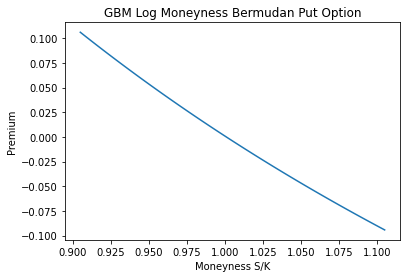

In [ ]:
plt.plot(strike, premiums)
plt.xlabel("Moneyness S/K")
plt.ylabel("Premium")
if call_option:
  plt.title("GBM Log Moneyness Bermudan Call Option")
  plt.savefig('GBM_B_Call_upper.png')
else:
  plt.title("GBM Log Moneyness Bermudan Put Option")
  plt.savefig('GBM_B_Put_upper.png')